In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.concept_utils import conceptExample, gate_score
import numpy as np

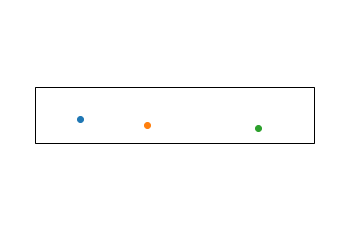

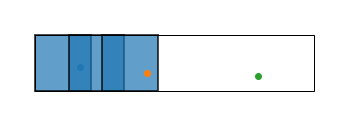

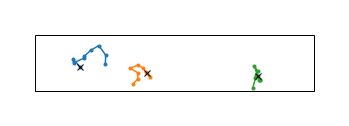

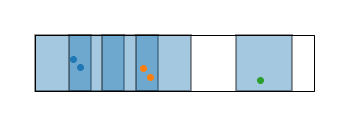

In [96]:
ce = conceptExample(var=0.1)

ce.plot_starting()
ce.plot_cams()
ce.plot_paths()
ce.plot_detections()


In [97]:
ce.df

,time,individual,x,y
0,0,0,0.800000,0.436386
1,1,0,0.675711,0.576379
2,2,1,2.056013,0.251097
3,3,1,1.930473,0.411045
4,6,2,4.021600,0.200827


In [138]:
def step_tracks(t, tracks, ce):
    det = ce.df[ce.df["time" ]==t]
    return ce.update_tracks(det, tracks)

In [139]:
def step_tracks_scores(t, tracks, ce, scores):
    det = ce.df[ce.df["time" ]==t]
#     gate_score(t, ce.df, ce.var, ce.thresh, np.multiply(*ce.cam_area), 3/5)
    return ce.update_score_tracks(det, tracks, scores)

In [140]:
ce.df

,time,individual,x,y
0,0,0,0.800000,0.436386
1,1,0,0.675711,0.576379
2,2,1,2.056013,0.251097
3,3,1,1.930473,0.411045
4,6,2,4.021600,0.200827


Make tracks and score them

In [141]:
tracks = ce.make_first_track()
scores = [0,0]

In [142]:
tracks1, scores1 = step_tracks_scores(1, tracks, ce, scores)
tracks2, scores2 = step_tracks_scores(2, tracks1, ce, scores1)
tracks3, scores3 = step_tracks_scores(3, tracks2, ce, scores2)
tracks4, scores4 = step_tracks_scores(4, tracks3, ce, scores3)
tracks5, scores5 = step_tracks_scores(5, tracks4, ce, scores4)
tracks6, scores6 = step_tracks_scores(6, tracks5, ce, scores5)

insnan last
insnan last
insnan last
Gated detection 4 from 0
Gated detection 4 from 3
Gated detection 4 from 2
Gated detection 4 from 3
Gated detection 4 from 1
Gated detection 4 from 3
Gated detection 4 from 2
Gated detection 4 from 3
insnan last
Gated detection 4 from 3
Gated detection 4 from 2
Gated detection 4 from 3
Gated detection 4 from 1
Gated detection 4 from 3
Gated detection 4 from 2
Gated detection 4 from 3


In [143]:
np.log(0.4)#1-ce.density * np.multiply(*ce.cam_area)

-0.916290731874155

In [144]:
for i, t in enumerate(tracks1):
    print(t, scores1[i])

[0, nan] -0.10536051565782628
[0, 1] 0.4351083332003166
[nan, nan] -0.10536051565782628
[nan, 1] -0.10536051565782628


In [145]:
for i, t in enumerate(tracks2):
    print(t, scores2[i])

[0, nan, nan] -0.21072103131565256
[0, nan, 2] -0.6176924311877154
[0, 1, nan] 0.32974781754249033
[0, 1, 2] 0.6755931158096689
[nan, nan, nan] -0.21072103131565256
[nan, nan, 2] -0.21072103131565256
[nan, 1, nan] -0.21072103131565256
[nan, 1, 2] 0.135124266951526


**Make graph**

In [146]:
tracks6 = [t for t in tracks6 if not np.isnan(t).all()]

In [147]:
gtrack = np.array(tracks6)

In [148]:
import igraph

Graph building
1. Each track is a node
2. tracks which share a detection are incompatible so have an edge between

Make a graph with n vertices (where n is number of tracks)

In [149]:
g = igraph.Graph()
nverts = len(gtrack)
g.add_vertices(nverts)

Find the incompatible tracks

In [150]:
edges = []

for i, tr in enumerate(gtrack):
    diff = tr - gtrack
    for d in np.where(diff==0)[0]:
        if d != i:
            edges.append((i, d))

add edges to the graph

In [151]:
g.add_edges(edges)

In [152]:
hyps = g.maximal_independent_vertex_sets()

In [153]:
hyps

[(0, 8, 9, 10, 12),
 (0, 8, 9, 14),
 (0, 8, 15),
 (0, 8, 10, 13),
 (0, 8, 11, 12),
 (1, 8, 10, 12),
 (1, 8, 14),
 (2, 8, 9, 12),
 (2, 8, 13),
 (3, 8, 12),
 (4, 8, 9, 10),
 (4, 8, 11),
 (5, 8, 10),
 (6, 8, 9),
 (7, 8)]

Score the generated hypotheses

In [154]:
def score_hypotheses(hyps, scores):
    hscores = []
    for hyp in hyps:
        hscores.append(np.sum([scores[h] for h in hyp]))
    return hscores

In [155]:
hscores = score_hypotheses(hyps,scores6 )

In [164]:
for z in zip(tracks6, scores6):
    print(z)

([0, nan, nan, nan, nan, nan, nan], -0.6321630939469578)
([0, nan, nan, 3, nan, nan, nan], -1.4703772701733007)
([0, nan, 2, nan, nan, nan, nan], -1.0391344938190208)
([0, nan, 2, 3, nan, nan, nan], -0.50121563122721)
([0, 1, nan, nan, nan, nan, nan], -0.0916942450888148)
([0, 1, nan, 3, nan, nan, nan], -0.4977711968270305)
([0, 1, 2, nan, nan, nan, nan], 0.2541510531783637)
([0, 1, 2, 3, nan, nan, nan], 0.792069915770174)
([nan, nan, nan, nan, nan, nan, 4], -0.6321630939469578)
([nan, nan, nan, 3, nan, nan, nan], -0.6321630939469578)
([nan, nan, 2, nan, nan, nan, nan], -0.6321630939469578)
([nan, nan, 2, 3, nan, nan, nan], -0.6321630939469578)
([nan, 1, nan, nan, nan, nan, nan], -0.09424423135514715)
([nan, 1, nan, 3, nan, nan, nan], -0.6321630939469578)
([nan, 1, 2, nan, nan, nan, nan], -1.0382400456851735)
([nan, 1, 2, 3, nan, nan, nan], -0.2863177956797791)


In [156]:
for i, h in enumerate(hscores):
    print(hyps[i], h)

(0, 8, 9, 10, 12) -2.6228966071429785
(0, 8, 9, 14) -2.934729327526047
(0, 8, 15) -1.5506439835736947
(0, 8, 10, 13) -2.528652375787831
(0, 8, 11, 12) -1.9907335131960204
(1, 8, 10, 12) -2.828947689422364
(1, 8, 14) -3.140780409805432
(2, 8, 9, 12) -2.3977049130680834
(2, 8, 13) -2.303460681712936
(3, 8, 12) -1.227622956529315
(4, 8, 9, 10) -1.9881835269296881
(4, 8, 11) -1.3560204329827303
(5, 8, 10) -1.7620973847209462
(6, 8, 9) -1.0101751347155519
(7, 8) 0.15990682182321625


In [157]:
nscores = []
for i, h in enumerate(hscores):
    nscores.append(h/len(hyps[i]))

In [158]:
np.argsort(nscores)

array([ 6,  8,  1,  5,  3,  7, 12,  0,  2,  4, 10, 11,  9, 13, 14])

In [159]:
np.argsort(hscores)

array([ 6,  1,  5,  0,  3,  7,  8,  4, 10, 12,  2, 11,  9, 13, 14])

In [162]:
[gtrack[h] for h in hyps[11]]

[array([ 0.,  1., nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan,  4.]),
 array([nan, nan,  2.,  3., nan, nan, nan])]

In [123]:
for i in [83, 101]:
    print( [gtrack[h] for h in hyps[i]])
    print(hscores[i])

IndexError: list index out of range

In [53]:
np.linalg.det(np.array([[3, 0], [0, 3]]))

9.000000000000002

In [97]:
np.log(0.01)

-4.605170185988091